### Tallest Buildings - population
first data cleaning

In [1]:
import pandas as pd

In [2]:
# note - went in and replaced "sao paulo" entries due to encoding annoyances
xl = pd.ExcelFile('(778114242) buildings_2016-03-10-21-20-21.xlsx')

In [37]:
DFs = []
DFs.append(xl.parse(xl.sheet_names[0], skiprows=1,
                    parse_cols=[0, 3, 8, 10, 12, 15, 18, 20, 24], convert_float=False,
                 names=['Rank', 'Building', 'City', 'Height_m', 'Height_ft', 'Floors', 
                        'DateComplete', 'Material', 'Use']))
for sheet in xl.sheet_names[1:]:
    DFs.append(xl.parse(sheet, parse_cols=[0, 2, 3, 4, 5, 6, 7, 8, 9], convert_float=False,
                 names=['Rank', 'Building', 'City', 'Height_m', 'Height_ft', 'Floors', 
                        'DateComplete', 'Material', 'Use']))
    
df = pd.concat(DFs)
# make dataframe's index unique
df.reset_index(inplace=True) 
df.drop('index', inplace=True, axis=1)

In [38]:
df.head()

,Rank,Building,City,Height_m,Height_ft,Floors,DateComplete,Material,Use
0,1,Burj Khalifa,Dubai,828.0,"2,717",163,2010,steel/concrete,office / residential /\nhotel
1,2,Shanghai Tower,Shanghai,632.0,"2,073",128,2015,composite,hotel / office
2,3,Makkah Royal C lock Tower,Mecca,601.0,"1,972",120,2012,steel/concrete,other / hotel
3,4,One World Trade C enter,New York C ity,541.3,"1,776",94,2014,composite,office
4,5,TAIPEI 101,Taipei,508.0,"1,667",101,2004,composite,office


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3358 entries, 0 to 3357
Data columns (total 9 columns):
Rank            3358 non-null float64
Building        3358 non-null object
City            3358 non-null object
Height_m        3358 non-null float64
Height_ft       3358 non-null object
Floors          3358 non-null object
DateComplete    3358 non-null float64
Material        2573 non-null object
Use             3342 non-null object
dtypes: float64(3), object(6)
memory usage: 262.3+ KB


#### geocode buildings to use distance from city center
both as (1) selection between cities with same name (b/c buildings dataset doesn't have country) and (2) distance gradient of buildings' height from city center

In [24]:
# get geographic coordinates of building
import geocoder

In [ ]:
# at least 1 building (in Brisbane) does not have a name, so force it to be type string
# getting errors, put in loop so at least some get calculated and can fill in errors...
#df['geoCoord'] = df.apply(lambda x: geocoder.osm(str(x['Name'])+','+str(x['City'])).latlng, axis=1)
# initialize columns
df['lat'] = 0. 
df['lon'] = 0.
for i, row in df.iterrows():
    Bldg = row['Building'][0:row['Building'].find(u'\u2026')] if type(row['Building'])!=float else str(row['Building'])
    # try OSM geocoder first
    res = geocoder.osm(Bldg+', '+str(row['City'])).latlng
    if len(res)==2:
        df.loc[i, 'lat'] = res[0]
        df.loc[i, 'lon'] = res[1]
    else:
        # if doesn't work try google
        res = geocoder.google(Bldg+', '+str(row['City'])).latlng
        if len(res)==2:
            df.loc[i, 'lat'] = res[0]
            df.loc[i, 'lon'] = res[1]
    #print row.Rank, Bldg+','+str(row['City'])

In [ ]:
df.head()

In [92]:
#geocoder.osm(df.loc[5,'Building']+','+str(df.loc[5,'City'])).latlng
test = geocoder.google(df.loc[5,'Building']+','+str(df.loc[5,'City'])).latlng
len(test)

2

In [93]:
test = geocoder.osm(df.loc[5,'Building']+','+str(df.loc[5,'City'])).latlng
len(test)

0

In [31]:
df[df.Rank==1].loc[:,'Building'].values[0]+','+str(df[df.Rank==1].loc[:,'City'].values[0])

u'Burj Khalifa,Dubai'

##### cities from Geonames database

In [5]:
# read in city location data (from geonames)
cities = pd.read_table('cities15000.txt', header=None, names=['geonameid', 'name', 'asciiname', 'alternatenames',
                                                             'city_lat', 'city_lon', 'f_class', 'f_code', 
                                                              'country_code','cc2', 'admin1', 'admin2', 'admin3', 
                                                              'admin4', 'population', 'elevation', 'dem', 
                                                              'timezone', 'mod_date'])

cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23018 entries, 0 to 23017
Data columns (total 19 columns):
geonameid         23018 non-null int64
name              23018 non-null object
asciiname         23018 non-null object
alternatenames    20350 non-null object
city_lat          23018 non-null float64
city_lon          23018 non-null float64
f_class           23018 non-null object
f_code            23018 non-null object
country_code      23005 non-null object
cc2               250 non-null object
admin1            23011 non-null object
admin2            14301 non-null object
admin3            4875 non-null object
admin4            1916 non-null object
population        23018 non-null int64
elevation         3509 non-null float64
dem               23018 non-null int64
timezone          23018 non-null object
mod_date          23018 non-null object
dtypes: float64(3), int64(3), object(13)
memory usage: 3.5+ MB


In [54]:
# create lower-case, no space columns for data join
df['city_ns'] = df.City.apply(lambda x: x.replace(" ", "").lower())
cities['city_ns'] = cities.asciiname.apply(lambda x: x.replace(" ", "").lower())

In [69]:
# stop-gap until get fully geocoded version
df_full = pd.merge(df, cities.loc[:,('name', 'city_lat', 'city_lon', 'country_code', 'population', 
                                     'dem', 'timezone', 'city_ns')], 
                   how='outer', left_on='city_ns', right_on='city_ns')
df_full = df_full[~df_full.Building.isnull()]
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3757 entries, 0 to 3756
Data columns (total 17 columns):
Rank            3757 non-null float64
Building        3757 non-null object
City            3757 non-null object
Height_m        3757 non-null float64
Height_ft       3757 non-null object
Floors          3757 non-null object
DateComplete    3757 non-null float64
Material        2909 non-null object
Use             3741 non-null object
city_ns         3757 non-null object
name            3635 non-null object
city_lat        3635 non-null float64
city_lon        3635 non-null float64
country_code    3635 non-null object
population      3635 non-null float64
dem             3635 non-null float64
timezone        3635 non-null object
dtypes: float64(7), object(10)
memory usage: 528.3+ KB


In [70]:
# remove duplicate - this just assumes duplicates are in the larger population location (based on a few samples)
# to be updated once fix geocoding above
df_full.sort_values(['Building', 'population'], ascending=[True, False], inplace=True)
df_full = df_full[~df_full.duplicated(['Rank', 'Building', 'City', 'Height_m', 'Height_ft','Floors', 
                                       'DateComplete', 'Material', 'Use'])]

In [71]:
df_full.head()

,Rank,Building,City,Height_m,Height_ft,Floors,DateComplete,Material,Use,city_ns,name,city_lat,city_lon,country_code,population,dem,timezone
2927,292,0,Brisbane,249.0,817,81,2014,concrete,residential,brisbane,Brisbane,-27.46794,153.02809,AU,2189878,27,Australia/Brisbane
871,1368,#1 Zhujiang Road Plaza,Nanjing,186.1,611,53,2007,NaN,office / hotel / retail,nanjing,Nanjing,32.06167,118.77778,CN,7165292,22,Asia/Shanghai
470,3212,1 Battery Park Plaza,New York C ity,151.0,495,35,1971,NaN,office,newyorkcity,New York City,40.71427,-74.00597,US,8175133,57,America/New_York
426,2330,1 Brooklyn Bridge Plaza,New York C ity,164.9,541,42,1976,NaN,office,newyorkcity,New York City,40.71427,-74.00597,US,8175133,57,America/New_York
343,1148,1 Dag Hammarskjold Plaza,New York C ity,194.2,637,48,1972,NaN,office,newyorkcity,New York City,40.71427,-74.00597,US,8175133,57,America/New_York


In [72]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 2927 to 1906
Data columns (total 17 columns):
Rank            3356 non-null float64
Building        3356 non-null object
City            3356 non-null object
Height_m        3356 non-null float64
Height_ft       3356 non-null object
Floors          3356 non-null object
DateComplete    3356 non-null float64
Material        2572 non-null object
Use             3340 non-null object
city_ns         3356 non-null object
name            3234 non-null object
city_lat        3234 non-null float64
city_lon        3234 non-null float64
country_code    3234 non-null object
population      3234 non-null float64
dem             3234 non-null float64
timezone        3234 non-null object
dtypes: float64(7), object(10)
memory usage: 471.9+ KB


In [75]:
# buildings of which rank do not have associated pop values
print df_full[df_full.population.isnull()].Rank.describe()

count     122.000000
mean     1572.860656
std       930.895750
min        85.000000
25%       715.000000
50%      1566.500000
75%      2403.750000
max      3329.000000
Name: Rank, dtype: float64


In [77]:
# select out subset of maybe useful columns and drop records that have missing data
df_v1 = df_full.loc[:,('Rank', 'Building', 'name', 'Height_m', 'Floors', 'city_lat', 'city_lon',
                      'population', 'dem')].dropna()
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3234 entries, 2927 to 1906
Data columns (total 9 columns):
Rank          3234 non-null float64
Building      3234 non-null object
name          3234 non-null object
Height_m      3234 non-null float64
Floors        3234 non-null object
city_lat      3234 non-null float64
city_lon      3234 non-null float64
population    3234 non-null float64
dem           3234 non-null float64
dtypes: float64(6), object(3)
memory usage: 252.7+ KB


#### some plots

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

(-1, 25)

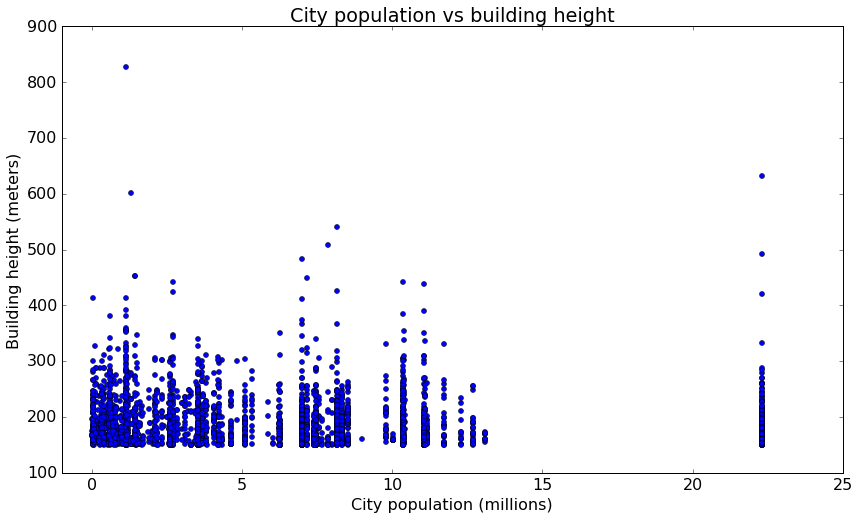

In [95]:
# simple population vs individual building heights
plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(figsize=(14,8))

ax.plot(df_v1.population/1000000, df_v1.Height_m, 'ob', markersize=5)
ax.set_ylabel('Building height (meters)')
ax.set_xlabel('City population (millions)')
ax.set_title('City population vs building height')
ax.set_xlim(-1, 25)

In [124]:
df_v1.loc[df_v1.population.idxmax(),:]

Rank                       2
Building      Shanghai Tower
name                Shanghai
Height_m                 632
Floors                   128
city_lat             31.2222
city_lon             121.458
population       2.23155e+07
dem                       12
Name: 151, dtype: object

In [96]:
tallest = df_v1.groupby('name')['Height_m', 'population'].max()
tallest.head()

,Height_m,population
name,,
Abu Dhabi,381.2,603492
Ajman,213.0,226172
Al Fujayrah,170.0,62415
Albany,179.5,97856
Almaty,168.0,2000900


(-1, 25)

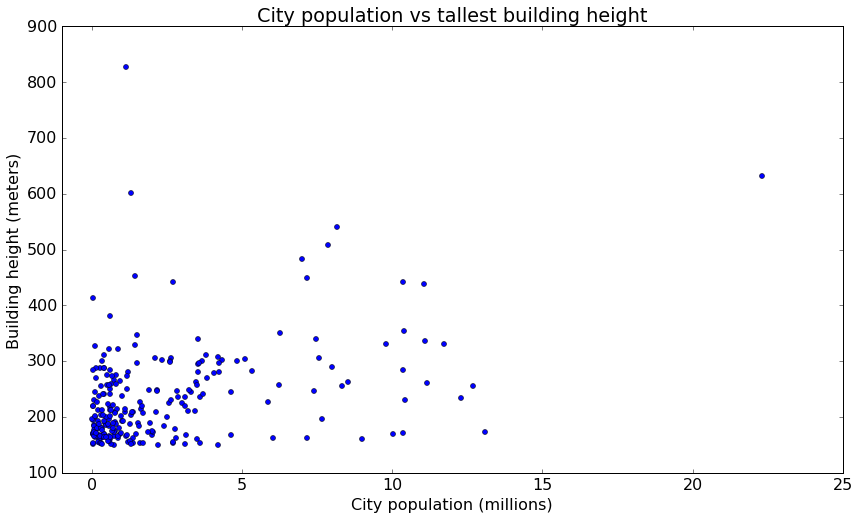

In [97]:
# simple population vs tallest building in city
plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(figsize=(14,8))

ax.plot(tallest.population/1000000, tallest.Height_m, 'ob', markersize=5)
ax.set_ylabel('Building height (meters)')
ax.set_xlabel('City population (millions)')
ax.set_title('City population vs tallest building height')
ax.set_xlim(-1, 25)

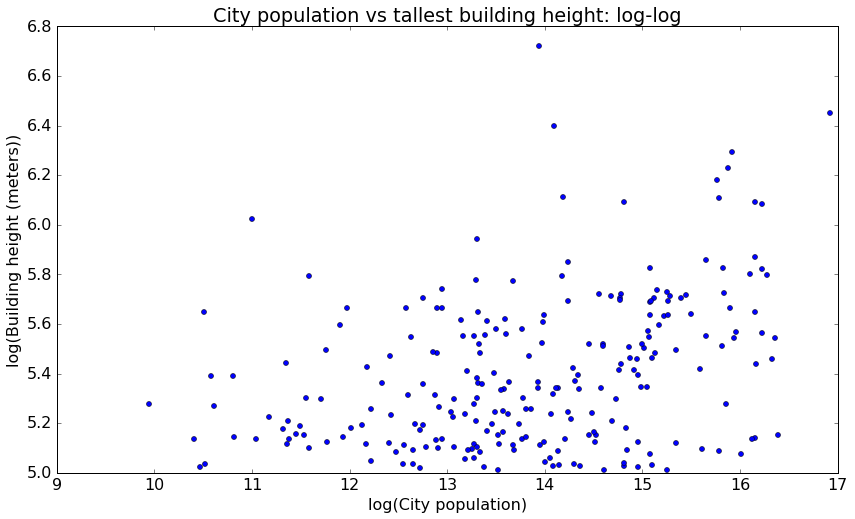

In [106]:
# simple log-log population vs tallest building in city
import numpy as np
plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(figsize=(14,8))

ax.plot(np.log(tallest.population), np.log(tallest.Height_m), 'ob', markersize=5)
ax.set_ylabel('log(Building height (meters))')
ax.set_xlabel('log(City population)')
ax.set_title('City population vs tallest building height: log-log')


In [129]:
# sort by city and building height
df_v1.sort_values(['name', 'Height_m'], inplace=True, ascending=False)
# get up to tallest 5 buildings in each city and aggregate building heights
tallest_5 = df_v1.groupby(['name', 'population']).head(5).\
groupby(['name', 'population'])['Height_m'].agg({'sum', 'mean', 'count'})
tallest_5.rename(columns={'sum': 'TotBldgHeight', 'mean': 'MeanBldgHeight', 'count': 'NumBldgs'}, inplace=True)
tallest_5.reset_index(inplace=True)
tallest_5.head()

,name,population,NumBldgs,TotBldgHeight,MeanBldgHeight
0,Abu Dhabi,603492,5,1644.7,328.94
1,Ajman,226172,1,213.0,213.00
2,Al Fujayrah,62415,2,325.0,162.50
3,Albany,97856,1,179.5,179.50
4,Almaty,2000900,1,168.0,168.00


In [130]:
tallest_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 5 columns):
name              243 non-null object
population        243 non-null float64
NumBldgs          243 non-null int64
TotBldgHeight     243 non-null float64
MeanBldgHeight    243 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.4+ KB


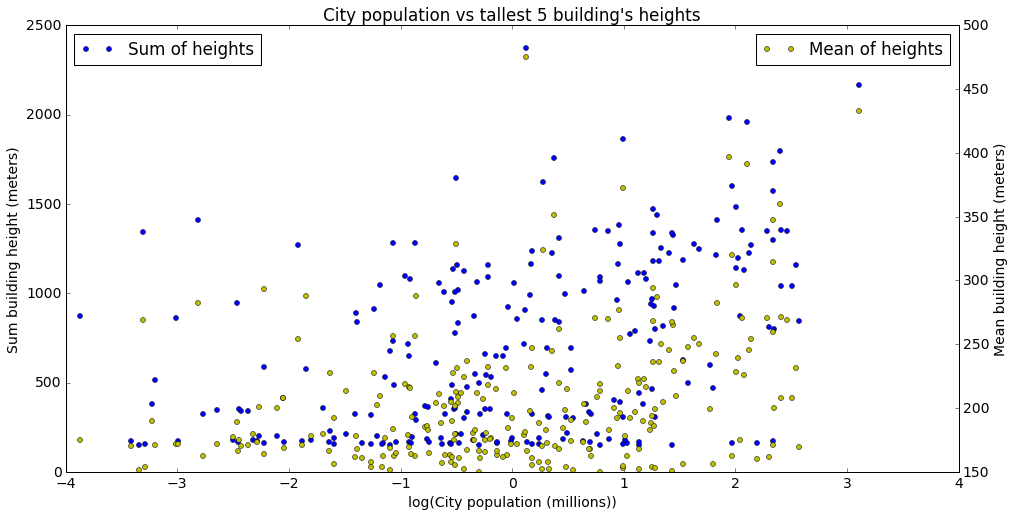

In [166]:
# simple population vs sum of tallest 5 buildings in city
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(16,8))

ax.plot(np.log(tallest_5.population/1000000), tallest_5.TotBldgHeight, 'ob', markersize=5, label='Sum of heights')
ax.set_xlabel('log(City population (millions))')
ax.set_xlim(-1,25)
ax1 = ax.twinx()
ax1.plot(np.log(tallest_5.population/1000000), tallest_5.MeanBldgHeight, 'oy', markersize=5, label='Mean of heights')
ax.set_title('City population vs tallest 5 building\'s heights')
ax.set_ylabel('Sum building height (meters)')
ax1.set_ylabel('Mean building height (meters)')
ax.legend(loc=2)
ax1.legend(loc=1)

In [164]:
import statsmodels.formula.api as smf
#reg_tallest = smf.ols(formula='Height_m ~ population', data=np.log(tallest)).fit()
reg_tallest = smf.ols(formula='TotBldgHeight ~ population', data=tallest_5).fit()
print reg_tallest.summary()

                            OLS Regression Results                            
Dep. Variable:          TotBldgHeight   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     68.37
Date:                Mon, 28 Mar 2016   Prob (F-statistic):           9.18e-15
Time:                        00:24:56   Log-Likelihood:                -1819.9
No. Observations:                 243   AIC:                             3644.
Df Residuals:                     241   BIC:                             3651.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    528.8902     34.935     15.139      0.0

In [ ]:
# grab and graph tallest 9

for n in range(1, 10):
    tn = df_v1.groupby(['name', 'population']).head(n).\
    groupby(['name', 'population'])['Height_m'].agg({'sum', 'mean', 'count'})
    tn.rename(columns={'sum': 'TotBldgHeight', 'mean': 'MeanBldgHeight', 'count': 'NumBldgs'}, inplace=True)
    tn.reset_index(inplace=True)
